In [45]:
%matplotlib inline

import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from data_io import load_excel_data, clean_observations, get_annual_summary

# Plotting style setup
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Colour palette
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#06A77D',
    'warning': '#D62246',
}

# load the data
data = load_excel_data('../data/raw/Observations 2012-2025.xlsx')
df_obs = data['observations']
df_species = data['species']
df_gps = data['gps']


Loading data from ../data/raw/Observations 2012-2025.xlsx
Loaded 86 species
Loaded 651 GPS points
Converting count columns to numeric
Loaded 114497 observation records


## Survey Protocol

This dataset follows a standardized breeding bird monitoring protocol:

- **Transect structure**: Each site contains **10 fixed observation points** arranged along a transect
- **Visit protocol**: Observers conduct **5-minute point counts** at each of the 10 points
- **Visitation frequency**: Each site is visited **at most twice** during the monitoring period
- **Detection recording**: All bird detections include species ID, count, and observer metadata

This standardized approach ensures comparable data across sites and years, though sampling effort varies (see below).

In [46]:
# Dataset Structure Summary Table
print("Dataset Structure\n")

sheet_summary = pd.DataFrame({
    'Sheet Name': ['Observations (NOM FRANÇAIS)', 'Species (ESPECES)', 'GPS (GPS-MILIEU)'],
    'Rows': [len(df_obs), len(df_species), len(df_gps)],
    'Columns': [df_obs.shape[1], df_species.shape[1], df_gps.shape[1]],
    'Description': [
        'Bird observation records (main data)',
        'Species taxonomy and migration status',
        'GPS coordinates and habitat types'
    ]
})

print(sheet_summary.to_string(index=False))
print(f"\nTotal observation records after cleaning: {len(clean_observations(df_obs)):,}")

Dataset Structure

                 Sheet Name   Rows  Columns                           Description
Observations (NOM FRANÇAIS) 114497       28  Bird observation records (main data)
          Species (ESPECES)     86        3 Species taxonomy and migration status
           GPS (GPS-MILIEU)    651        4     GPS coordinates and habitat types
Data Cleaning
Starting with 114497 records
⚠ Found 5 negative wind values - setting to NaN
Removed 4 records with zero/negative counts
Final dataset: 114493 records
  Years: 2014 - 2025
  Unique species: 102
  Unique transects: 72
  Unique observers: 42

Total observation records after cleaning: 114,493


In [47]:
# clean it up
df_clean = clean_observations(df_obs)

Data Cleaning
Starting with 114497 records
⚠ Found 5 negative wind values - setting to NaN
Removed 4 records with zero/negative counts
Final dataset: 114493 records
  Years: 2014 - 2025
  Unique species: 102
  Unique transects: 72
  Unique observers: 42


In [48]:
# Data Quality Issues and Solutions
print("Critical Data Quality Issues")

print("1. Datetime encoding of counts")
print("   Problem: Count data was stored as datetime64 (Excel import artifact)")
print("   Solution: Extracted counts from nanosecond component of timestamps")
print("   Impact: Affected 100% of observations, but its now corrected\n")

print("2. Partial years")
print(f"   2014: {df_clean[df_clean.year == 2014]['date'].min().strftime('%B %d')} to {df_clean[df_clean.year == 2014]['date'].max().strftime('%B %d')} (partial)")
print(f"   2025: {df_clean[df_clean.year == 2025]['date'].min().strftime('%B %d')} to {df_clean[df_clean.year == 2025]['date'].max().strftime('%B %d')} (partial)")
print("   We will focus analyses mainly on complete years\n")

print("3. Observer effect")
top_observer = df_clean.groupby('observer_name').size().sort_values(ascending=False).iloc[0]
top_obs_name = df_clean.groupby('observer_name').size().sort_values(ascending=False).index[0]
obs_pct = (top_observer / len(df_clean)) * 100
print(f"   One observer ({top_obs_name}) conducted {obs_pct:.1f}% of all observations")
print("   Impact: Potential observer-specific detection biases\n")

print("4. Missing species metadata")
n_species_obs = df_clean['species_name'].nunique()
n_species_lookup = len(df_species)
print(f"   {n_species_obs} species observed, but only {n_species_lookup} in lookup table")
print(f"   {n_species_obs - n_species_lookup} species lack scientific names and migration status\n")

print("5. Distance bands")
print("   Distance sampling data is mostly missing")
print("   Analysis will focus on total counts only\n")

print("6. Negative wind values")
print(f"   Found {(df_obs['wind'] < 0).sum()} observations with negative wind values (data errors)")
print("   Solution: Set to NaN while retaining bird observations")


Critical Data Quality Issues
1. Datetime encoding of counts
   Problem: Count data was stored as datetime64 (Excel import artifact)
   Solution: Extracted counts from nanosecond component of timestamps
   Impact: Affected 100% of observations, but its now corrected

2. Partial years
   2014: March 29 to June 22 (partial)
   2025: April 01 to July 03 (partial)
   We will focus analyses mainly on complete years

3. Observer effect
   One observer (CONDE Beatriz) conducted 36.5% of all observations
   Impact: Potential observer-specific detection biases

4. Missing species metadata
   102 species observed, but only 86 in lookup table
   16 species lack scientific names and migration status

5. Distance bands
   Distance sampling data is mostly missing
   Analysis will focus on total counts only

6. Negative wind values
   Found 5 observations with negative wind values (data errors)
   Solution: Set to NaN while retaining bird observations


### Detection Modality Data

The dataset contains separate count columns for different detection methods:
- `count_auditory`: Birds detected by sound only
- `count_visual_no_flight`: Birds detected visually (not flying)  
- `count_audio_visual_no_flight`: Birds detected by both sound and sight (not flying)
- `count_audio_visual_flight`: Birds detected by both methods while in flight

These are summed to create `individual_count`. While the original dataset uses multiple columns tracking detection modality, we chose to not focus on this. Distance sampling data (Unnamed: 13-20) remains largely empty (>70% missing cells) and will not be used in our trend analyses.

In [49]:
# get annual summary
annual_summary = get_annual_summary(df_clean)
annual_summary

,n_observations,n_species,total_abundance,n_transects,n_observers
year,,,,,
2014,5377,63,32643.000000,41,24
2015,8162,70,52453.000000,53,26
2016,11010,77,69062.000000,59,28
2017,9228,71,61685.380952,60,27
2018,9733,73,61208.000000,65,23
2019,9572,70,63217.000000,64,21
2020,9956,68,66171.000000,63,15
2021,10604,69,72048.000000,63,13
2022,10804,68,73549.000000,63,15


In [50]:
# Basic Dataset Overview
print("Basic Dataset Overview")

print("\nTemporal Coverage:")
print(f"  First observation: {df_clean['date'].min().strftime('%Y-%m-%d')}")
print(f"  Last observation:  {df_clean['date'].max().strftime('%Y-%m-%d')}")
print(f"  Total years:       {df_clean['year'].nunique()}")
print(f"  Year range:        {int(df_clean['year'].min())} - {int(df_clean['year'].max())}")

print("\nSpatial Coverage:")
print(f"  Unique transects:  {df_clean['transect_name'].nunique()}")
print(f"  Unique points:     {df_clean['point_number'].nunique()} (1-10 per transect)")

print("\nSpecies Diversity:")
print(f"  Unique species:    {df_clean['species_name'].nunique()}")
print(f"  Total individuals: {df_clean['individual_count'].sum():,.0f}")

print("\nSampling Effort:")
print(f"  Total observations: {len(df_clean):,}")
print(f"  Unique observers:   {df_clean['observer_name'].nunique()}")

print("\nCount Statistics:")
print(f"  Mean birds/observation:   {df_clean['individual_count'].mean():.1f}")
print(f"  Median birds/observation: {df_clean['individual_count'].median():.0f}")
print(f"  Max birds/observation:    {df_clean['individual_count'].max():.0f}")

Basic Dataset Overview

Temporal Coverage:
  First observation: 2014-03-29
  Last observation:  2025-07-03
  Total years:       12
  Year range:        2014 - 2025

Spatial Coverage:
  Unique transects:  72
  Unique points:     10 (1-10 per transect)

Species Diversity:
  Unique species:    102
  Total individuals: 747,639

Sampling Effort:
  Total observations: 114,493
  Unique observers:   42

Count Statistics:
  Mean birds/observation:   6.5
  Median birds/observation: 6
  Max birds/observation:    600


## Data Quality Assessment

The following sections examine data quality issues that may affect downstream analyses.

### Weather Conditions

In [51]:
# Environmental Conditions Summary
print("Weather Conditions During Surveys")

weather_summary = pd.DataFrame({
    'Variable': ['Wind', 'Rain', 'Cloud Cover', 'Visibility'],
    'Non-Missing': [
        df_clean['wind'].notna().sum(),
        df_clean['rain'].notna().sum(),
        df_clean['cloud_cover_raw'].notna().sum(),
        df_clean['visibility'].notna().sum()
    ],
    'Missing (%)': [
        f"{df_clean['wind'].isna().sum() / len(df_clean) * 100:.1f}%",
        f"{df_clean['rain'].isna().sum() / len(df_clean) * 100:.1f}%",
        f"{df_clean['cloud_cover_raw'].isna().sum() / len(df_clean) * 100:.1f}%",
        f"{df_clean['visibility'].isna().sum() / len(df_clean) * 100:.1f}%"
    ]
})

print(weather_summary.to_string(index=False))
print()

# Convert cloud_cover to numeric for descriptive stats
df_clean['cloud_cover'] = pd.to_numeric(df_clean['cloud_cover_raw'], errors='coerce')

# Descriptive statistics for weather variables
print("Weather Variable Distributions:")
print(df_clean[['wind', 'rain', 'cloud_cover', 'visibility']].describe())

Weather Conditions During Surveys
   Variable  Non-Missing Missing (%)
       Wind       114471        0.0%
       Rain       114492        0.0%
Cloud Cover       114492        0.0%
 Visibility       114492        0.0%

Weather Variable Distributions:
                wind           rain    cloud_cover     visibility
count  114471.000000  114492.000000  114491.000000  114492.000000
mean        1.423068       1.029338       1.968163       1.419549
std         0.600080       0.177482       0.698644       0.619842
min         0.000000       1.000000       1.000000       1.000000
25%         1.000000       1.000000       1.000000       1.000000
50%         1.000000       1.000000       2.000000       1.000000
75%         2.000000       1.000000       2.000000       2.000000
max         3.000000       3.000000       3.000000       4.000000


### Missing Values

We assess completeness across all columns to identify data gaps.

In [52]:
# Comprehensive Missing Values Analysis
print("Missing Values Analysis\n")

# Create full missing values table
missing_analysis = pd.DataFrame({
    'Column': df_clean.columns,
    'Missing_Count': df_clean.isnull().sum(),
    'Missing_Percent': (df_clean.isnull().sum() / len(df_clean) * 100).round(1)
}).sort_values('Missing_Percent', ascending=False)

# Filter to columns with missing data
missing_with_data = missing_analysis[missing_analysis['Missing_Count'] > 0]

print("Columns with missing values:")
print(missing_with_data.to_string(index=False))

print(f"\n{len(missing_with_data)} out of {len(df_clean.columns)} columns have missing data")

# Highlight essential columns status (we dont use the detection modality columns)
essential_cols = ['observer_name', 'transect_name', 'species_name', 'date', 
                  'year', 'individual_count', 'point_number', 'visit_number']
essential_complete = [col for col in essential_cols if df_clean[col].isnull().sum() == 0]

print(f"\nEssential columns: {len(essential_complete)}/{len(essential_cols)} complete")
print("  All core fields required for trend analysis are complete ✓")

Missing Values Analysis

Columns with missing values:
                      Column  Missing_Count  Missing_Percent
                 Unnamed: 19         113105             98.8
                 Unnamed: 17         112962             98.7
                 Unnamed: 20         112672             98.4
                 Unnamed: 18         111845             97.7
                 Unnamed: 15         109061             95.3
                 Unnamed: 16         106091             92.7
                 Unnamed: 14          83345             72.8
                 Unnamed: 13          75302             65.8
       distance_category_raw          55664             48.6
              count_auditory            240              0.2
count_audio_visual_no_flight              6              0.0
      count_visual_no_flight              4              0.0
             department_code              2              0.0
                  visibility              1              0.0
                        wind   

### Outlier Detection

We use the IQR method to identify unusually high count observations.

In [53]:
# Outlier Analysis for Count Data
print("Outlier Analysis\n")

# Calculate outlier thresholds using IQR method
Q1 = df_clean['individual_count'].quantile(0.25)
Q3 = df_clean['individual_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_clean[df_clean['individual_count'] > upper_bound]

print(f"Count Distribution:")
print(f"  Q1 (25th percentile): {Q1:.1f}")
print(f"  Q3 (75th percentile): {Q3:.1f}")
print(f"  IQR: {IQR:.1f}")
print(f"  Upper outlier threshold: {upper_bound:.1f}")
print(f"\nOutliers detected: {len(outliers)} observations ({len(outliers)/len(df_clean)*100:.2f}%)")
print(f"  Max count: {df_clean['individual_count'].max():.0f} individuals")

# Show a few examples of outliers
if len(outliers) > 0:
    print(f"\nTop 5 largest counts:")
    print(outliers.nlargest(5, 'individual_count')[
        ['date', 'transect_name', 'species_name', 'individual_count', 'observer_name']
    ].to_string(index=False))

Outlier Analysis

Count Distribution:
  Q1 (25th percentile): 3.0
  Q3 (75th percentile): 9.0
  IQR: 6.0
  Upper outlier threshold: 18.0

Outliers detected: 3364 observations (2.94%)
  Max count: 600 individuals

Top 5 largest counts:
      date     transect_name       species_name  individual_count                                  observer_name
2025-06-18 Ilets du François  Sterne de Dougall             600.0 AGAT Arnaud-FREMACX Vincent- NOSEL Christopher
2025-05-06   Ilets du Robert Sterne fuligineuse             600.0                              BELLUMEUR Wilfrid
2018-05-25    Fonds Préville   Héron garde-bœuf             456.0                             MOURIESSE Jocelyne
2020-06-10   Ilets du Robert Sterne fuligineuse             450.0                              BELLUMEUR Wilfrid
2022-06-10   Ilets du Robert Sterne fuligineuse             450.0                              BELLUMEUR Wilfrid


## Exploratory Visualizations

The following plots examine temporal patterns, spatial coverage, species diversity, and sampling effort.

In [55]:
# Temporal Coverage Plot
annual_counts = df_clean.groupby('year').agg({
    'observation_id': 'count'
}).rename(columns={'observation_id': 'N_Obs'})

years = annual_counts.index.values
obs_counts = annual_counts['N_Obs'].values

# Identify partial years for highlighting
partial_years = [i for i, year in enumerate(years) if year in [2014, 2025]]

# Create figure and plot
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare colors
colors = [COLORS['warning'] if i in partial_years else COLORS['primary'] 
          for i in range(len(years))]

# Plot bars
ax.bar(years, obs_counts, color=colors, edgecolor='black', alpha=0.8)

# Add labels on highlighted bars
for idx, label in zip(partial_years, ['Partial\nYear'] * len(partial_years)):
    ax.text(idx, obs_counts[idx] + max(obs_counts)*0.02, label, 
           ha='center', va='bottom', fontsize=9, 
           color='darkred', fontweight='bold')

# Styling
ax.set_xlabel('Year', fontweight='bold', fontsize=12)
ax.set_ylabel('Number of Observations', fontweight='bold', fontsize=12)
ax.set_title('Observation Effort Over Time', fontweight='bold', fontsize=14)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

# Save figure
filename = '../figures/eda_temporal_coverage.png'
parent = os.path.dirname(filename)
if parent:
    os.makedirs(parent, exist_ok=True)
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {filename}")

/var/folders/06/lg555z950dl8y4c9fzhdsrnc0000gp/T/ipykernel_28950/252641252.py:34: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


TimeoutError: [Errno 60] Operation timed out

Saved: ../figures/eda_spatial_coverage.png


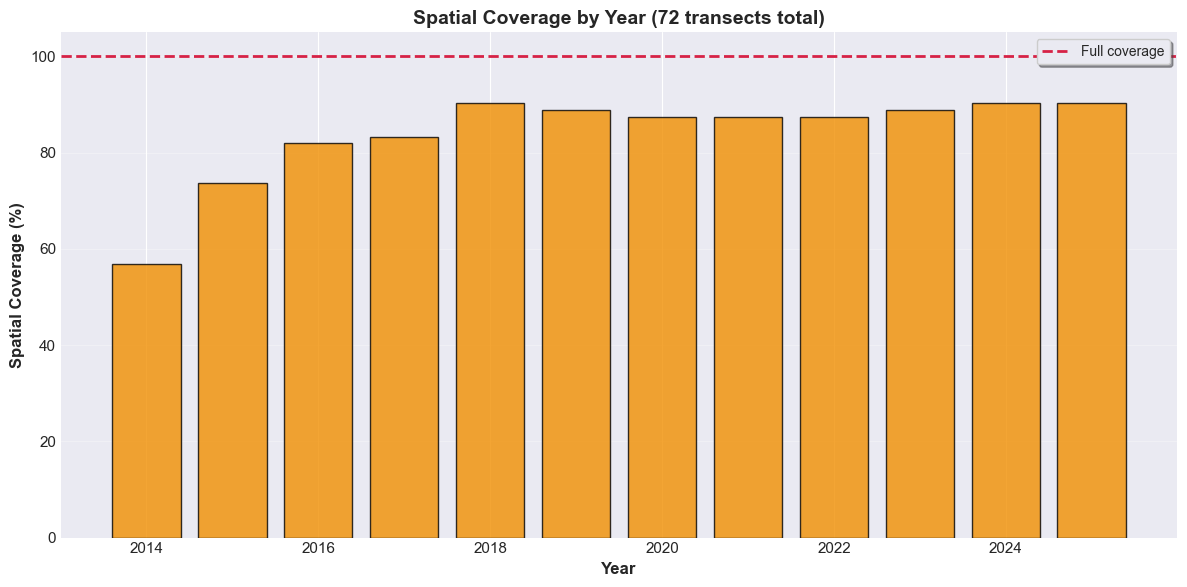


 Sampling Effort Variation

Temporal variation (coefficient of variation): 15.9%
  Min effort year: 5,377 obs (2014)
  Max effort year: 11,010 obs (2016)

Spatial variation (coefficient of variation): 40.1%
  Min effort transect: 5 obs
  Max effort transect: 2878 obs

Implication: Effort variation means we should
  - Use effort-standardized metrics (counts per point)
  - Account for sampling intensity in temporal trend models
  - Consider rarefaction for species richness comparisons

Key insight: No year achieved 100% transect coverage
  Average coverage: 84%
  This variation must be considered in temporal trend analyses


In [ ]:
# Spatial Coverage Plot
transects_per_year = df_clean.groupby('year')['transect_name'].nunique()
total_transects = df_clean['transect_name'].nunique()
coverage_pct = (transects_per_year / total_transects * 100)

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(transects_per_year.index.astype(int), coverage_pct.values, 
       color=COLORS['accent'], edgecolor='black', alpha=0.8)
ax.axhline(y=100, color=COLORS['warning'], linestyle='--', 
           linewidth=2, label='Full coverage')
ax.set_xlabel('Year', fontweight='bold', fontsize=12)
ax.set_ylabel('Spatial Coverage (%)', fontweight='bold', fontsize=12)
ax.set_title(f'Spatial Coverage by Year ({total_transects} transects total)', 
             fontweight='bold', fontsize=14)
ax.legend(frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

# Save with robust method
import os
os.makedirs('../figures', exist_ok=True)
plt.savefig('../figures/eda_spatial_coverage.png', dpi=300, bbox_inches='tight', format='png')
print("Saved: ../figures/eda_spatial_coverage.png")
# Plot will display automatically in notebook with %matplotlib inline

# Sampling Effort Variation Analysis
print("\n Sampling Effort Variation\n")

# Temporal variation
effort_by_year = df_clean.groupby('year').size()
cv_temporal = (effort_by_year.std() / effort_by_year.mean()) * 100

print(f"Temporal variation (coefficient of variation): {cv_temporal:.1f}%")
print(f"  Min effort year: {effort_by_year.min():,} obs ({effort_by_year.idxmin()})")
print(f"  Max effort year: {effort_by_year.max():,} obs ({effort_by_year.idxmax()})")

# Spatial variation
effort_by_transect = df_clean.groupby('transect_name').size()
cv_spatial = (effort_by_transect.std() / effort_by_transect.mean()) * 100

print(f"\nSpatial variation (coefficient of variation): {cv_spatial:.1f}%")
print(f"  Min effort transect: {effort_by_transect.min()} obs")
print(f"  Max effort transect: {effort_by_transect.max()} obs")

print("\nImplication: Effort variation means we should")
print("  - Use effort-standardized metrics (counts per point)")
print("  - Account for sampling intensity in temporal trend models")
print("  - Consider rarefaction for species richness comparisons")

print("\nKey insight: No year achieved 100% transect coverage")
print(f"  Average coverage: {coverage_pct.mean():.0f}%")
print("  This variation must be considered in temporal trend analyses")

### Species: simple summaries and plots

Below we summarise species-level totals and richness over time to understand which species dominate counts and how diversity changes annually.

✓ Saved: ../figures/eda_species_top20.png


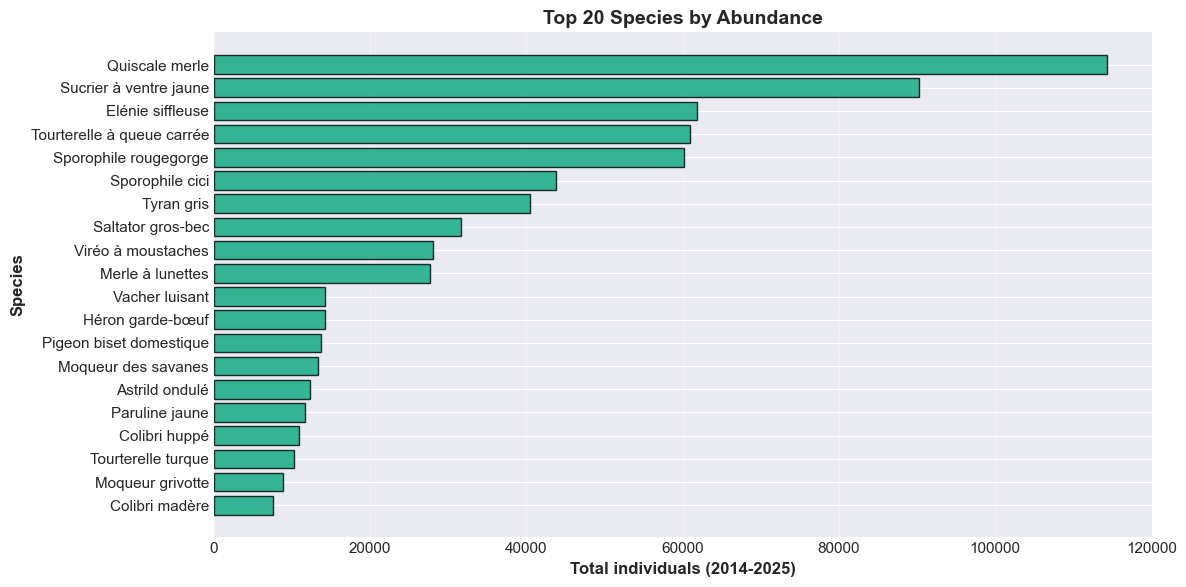

In [ ]:
# Top 20 species by total individuals
species_totals = (
    df_clean.groupby('species_name')['individual_count']
            .sum()
            .sort_values(ascending=False)
)

top_n = 20
top_species = species_totals.head(top_n)

# Create figure and plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot horizontal bars
ax.barh(top_species.index[::-1], top_species.values[::-1], 
        color=COLORS['success'], edgecolor='black', alpha=0.8)

# Styling
ax.set_xlabel('Total individuals (2014-2025)', fontweight='bold', fontsize=12)
ax.set_ylabel('Species', fontweight='bold', fontsize=12)
ax.set_title(f'Top {top_n} Species by Abundance', fontweight='bold', fontsize=14)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()

# Save figure
filename = '../figures/eda_species_top20.png'
parent = os.path.dirname(filename)
if parent:
    os.makedirs(parent, exist_ok=True)
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {filename}")

✓ Saved: ../figures/eda_species_accumulation.png


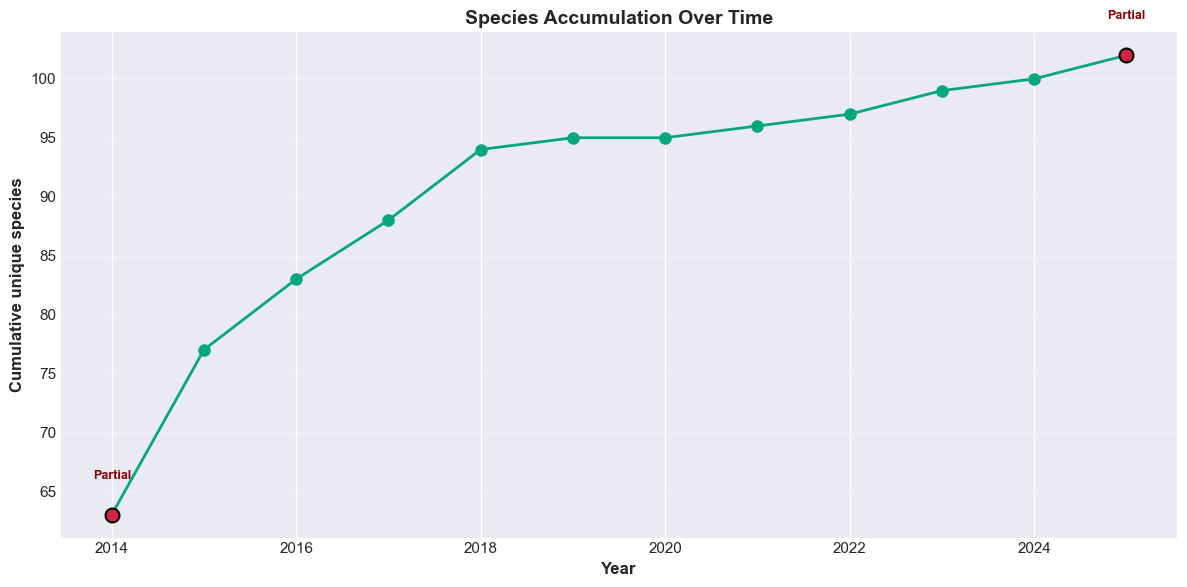

In [ ]:
# Cumulative species accumulation
cumulative_species = []
all_species_seen = set()

for year in sorted(df_clean['year'].unique()):
    year_species = set(df_clean[df_clean['year'] == year]['species_name'])
    all_species_seen.update(year_species)
    cumulative_species.append(len(all_species_seen))

years_sorted = sorted(df_clean['year'].unique())

# Create figure and plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot line
ax.plot(years_sorted, cumulative_species, marker='o', linewidth=2, 
        color=COLORS['success'], markersize=8)

# Highlight specific points
highlight_points = [2014, 2025]
for point in highlight_points:
    if point in years_sorted:
        idx = list(years_sorted).index(point)
        ax.scatter([point], [cumulative_species[idx]], color=COLORS['warning'], 
                  s=100, zorder=3, edgecolor='black', linewidth=1.5)

# Add labels
for point, label in zip(highlight_points, ['Partial', 'Partial']):
    if point in years_sorted:
        idx = list(years_sorted).index(point)
        ax.text(point, cumulative_species[idx] + max(cumulative_species)*0.03, label, 
               ha='center', fontsize=9, color='darkred', fontweight='bold')

# Styling
ax.set_xlabel('Year', fontweight='bold', fontsize=12)
ax.set_ylabel('Cumulative unique species', fontweight='bold', fontsize=12)
ax.set_title('Species Accumulation Over Time', fontweight='bold', fontsize=14)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

# Save figure
filename = '../figures/eda_species_accumulation.png'
parent = os.path.dirname(filename)
if parent:
    os.makedirs(parent, exist_ok=True)
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {filename}")

### Observer effort: simple summaries and plots

We assess how sampling effort is distributed across observers and over time.


✓ Saved: ../figures/eda_observer_effort.png


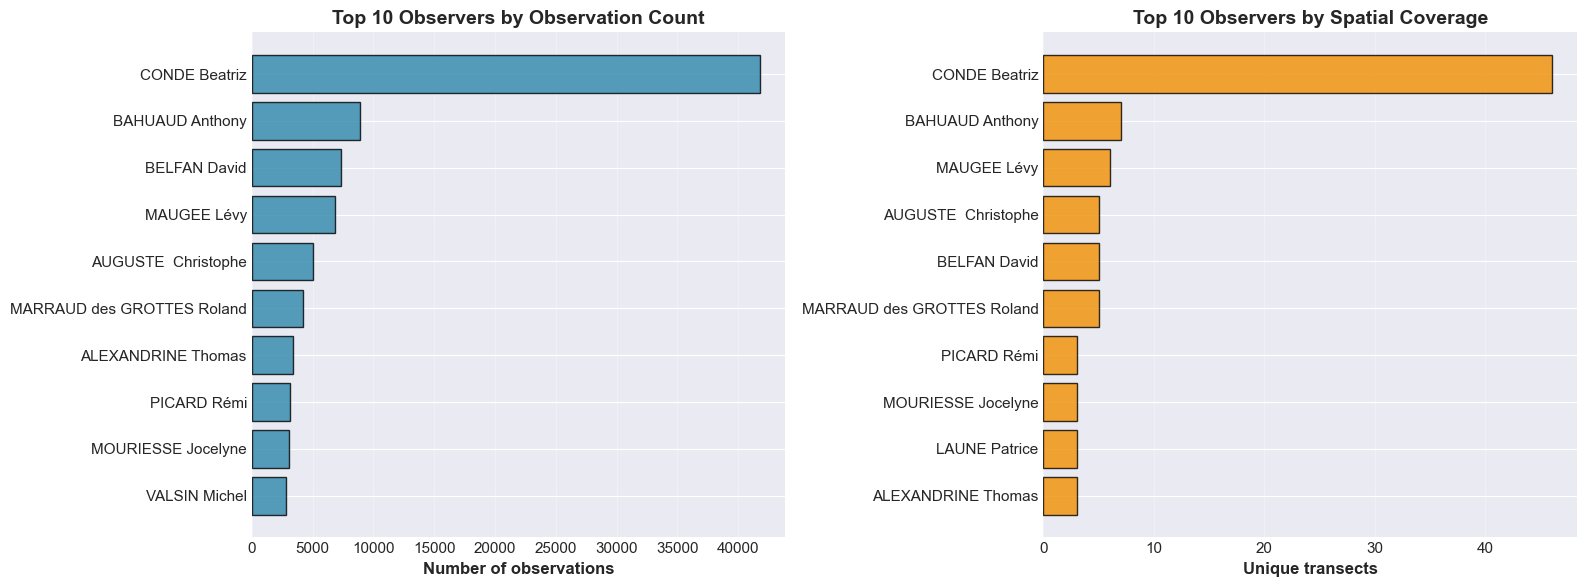

In [ ]:
# Observer Effort Analysis
obs_by_observer = df_clean.groupby('observer_name').size().sort_values(ascending=False)
transects_by_observer = df_clean.groupby('observer_name')['transect_name'].nunique().sort_values(ascending=False)

n = 10
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot
ax1.barh(obs_by_observer.head(n).index[::-1], 
         obs_by_observer.head(n).values[::-1], 
         color=COLORS['primary'], edgecolor='black', alpha=0.8)
ax1.set_xlabel('Number of observations', fontweight='bold', fontsize=12)
ax1.set_title(f'Top {n} Observers by Observation Count', fontweight='bold', fontsize=14)
ax1.grid(axis='x', alpha=0.3)

# Right plot
ax2.barh(transects_by_observer.head(n).index[::-1], 
         transects_by_observer.head(n).values[::-1], 
         color=COLORS['accent'], edgecolor='black', alpha=0.8)
ax2.set_xlabel('Unique transects', fontweight='bold', fontsize=12)
ax2.set_title(f'Top {n} Observers by Spatial Coverage', fontweight='bold', fontsize=14)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()

# Save figure
filename = '../figures/eda_observer_effort.png'
parent = os.path.dirname(filename)
if parent:
    os.makedirs(parent, exist_ok=True)
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {filename}")